In [1]:
%matplotlib inline
import numpy as np
from math import sqrt
import pandas as pd
import matplotlib.pylab as plt
import seaborn as sns
sns.set_context('notebook')

RANDOM_SEED = 20090425

## 2. Dataset: Nashville Precipitation

In [3]:
precip = pd.read_table("data/nashville_precip.txt", index_col=0, na_values='NA', delim_whitespace=True)
precip.head();

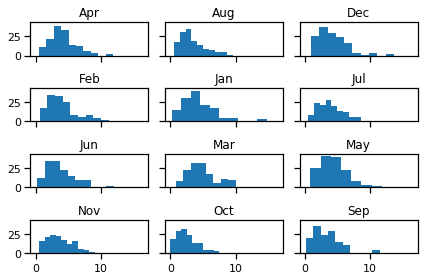

In [4]:
_ = precip.hist(sharex=True, sharey=True, grid=False)
plt.tight_layout()

## 3. Data Cleansing 
Since there is some missing data


In [5]:
precip.fillna(value={'Oct': precip.Oct.mean()}, inplace=True)
precip.head();

## 4. Exploration

Calculating the **means** and **variances** of precipitation, month by month:

In [6]:
precip_mean = precip.mean()
precip_mean

Jan    4.523688
Feb    4.097801
Mar    4.977589
Apr    4.204468
May    4.325674
Jun    3.873475
Jul    3.895461
Aug    3.367305
Sep    3.377660
Oct    2.610500
Nov    3.685887
Dec    4.176241
dtype: float64

In [7]:
precip_var = precip.var()
precip_var

Jan    6.928862
Feb    5.516660
Mar    5.365444
Apr    4.117096
May    5.306409
Jun    5.033206
Jul    3.777012
Aug    3.779876
Sep    4.940099
Oct    2.741659
Nov    3.679274
Dec    5.418022
dtype: float64

In [8]:
precip.Apr

Year
1871     4.13
1872     5.91
1873     3.59
1874    11.84
1875     4.22
        ...  
2007     2.75
2008     7.20
2009     4.13
2010     3.48
2011     7.51
Name: Apr, Length: 141, dtype: float64

# Finding Gamma Parameters $\alpha$ and $\beta$ 

Taking numbers, and modeling them as distributions, so that we can take a probabilistic program to figure out the best values for these parameters. 
First Trying it first for April Month Only.

/usr/local/lib/python3.7/site-packages/pandas/plotting/_matplotlib/hist.py:316: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


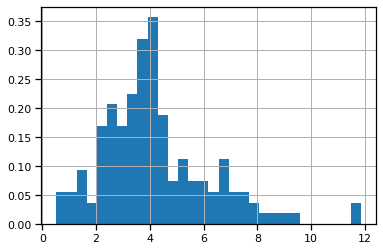

In [9]:
precip.Apr.hist(normed=True, bins=30)

# Finding $\alpha$ and $\beta$ using Uniform Distribution.

In [9]:
from pymc3 import Model, Uniform , Gamma

with Model() as rainfall_model:
    ualpha = Uniform('ualpha', lower=0, upper=15)
    ubeta = Uniform('ubeta', lower=0, upper=15)

with rainfall_model:
    april_like = Gamma('april_like', alpha=ualpha, beta=ubeta, observed=precip.Apr)

In [10]:
from pymc3 import fit

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)
    

Average Loss = 368.14: 100%|██████████| 10000/10000 [00:03<00:00, 2961.70it/s]
Finished [100%]: Average Loss = 368


/Users/makinsane/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


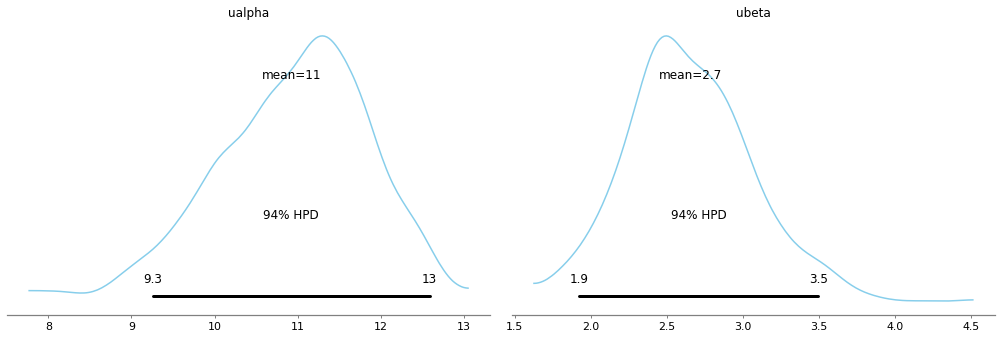

In [11]:
from pymc3 import plot_posterior

plot_posterior(rainfall_trace[100:], 
                varnames=['ualpha', 'ubeta'],
                color='#87ceeb');


## Trying To Fit The Data using the $\alpha$ and $\beta$ values

/Users/makinsane/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:2477: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


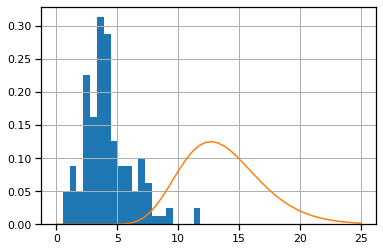

In [12]:
from scipy.stats.distributions import gamma

ualpha_posterior_mean = 11
ubeta_posterior_mean = 2.7

precip.Apr.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), ualpha_posterior_mean, ubeta_posterior_mean))

# Finding $\alpha$ and $\beta$ using Normal Distribution.

In [13]:
from pymc3 import Model, Uniform , Normal , Exponential

precip_mean_apr = precip_mean.Apr
precip_var_apr = sqrt(precip_var.Apr)

with Model() as rainfall_model:
    ualpha = Normal('ualpha', mu=precip_mean_apr, sigma=precip_var_apr)
    ubeta = Normal('ubeta', mu=precip_mean_apr, sigma=precip_var_apr)

with rainfall_model:
    april_like = Gamma('april_like', alpha=ualpha, beta=ubeta, observed=precip.Apr)

/Users/makinsane/anaconda3/lib/python3.7/site-packages/pymc3/distributions/continuous.py:88: UserWarning: The variable specified for alpha has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)
/Users/makinsane/anaconda3/lib/python3.7/site-packages/pymc3/distributions/continuous.py:88: UserWarning: The variable specified for beta has negative support for Gamma, likely making it unsuitable for this parameter.
  warnings.warn(msg)


In [14]:
from pymc3 import fit

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 329.43: 100%|██████████| 10000/10000 [00:02<00:00, 3567.98it/s]
Finished [100%]: Average Loss = 329.21


/Users/makinsane/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


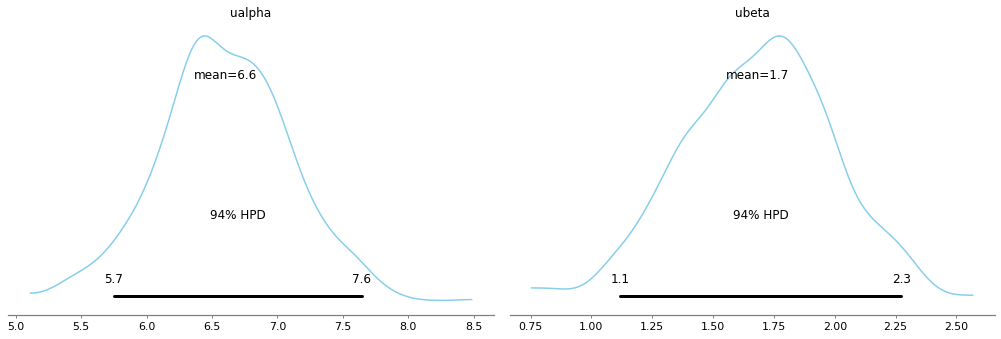

In [15]:
from pymc3 import plot_posterior

plot_posterior(rainfall_trace[100:], 
                varnames=['ualpha', 'ubeta'],
                color='#87ceeb');

## Trying To Fit The Data using the $\alpha$ and $\beta$ values

/Users/makinsane/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:2477: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


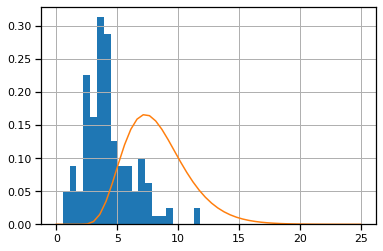

In [16]:
from scipy.stats.distributions import gamma

ualpha_posterior_mean = 6.6
ubeta_posterior_mean = 1.7

precip.Apr.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), ualpha_posterior_mean, ubeta_posterior_mean))

# Finding $\alpha$ and $\beta$ using Exponential Distribution.

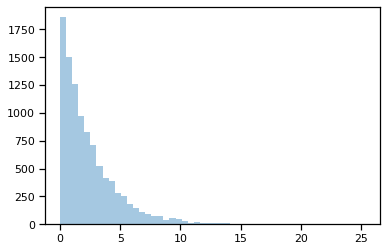

In [57]:
sns.distplot(Exponential.dist(2/5).random(size=10000), kde=False);

In [18]:
from pymc3 import Model, Uniform , Normal , Exponential

with Model() as rainfall_model:
    ualpha = Exponential('ualpha', 2/5 )
    ubeta = Exponential('ubeta',2/5)

with rainfall_model:
    april_like = Gamma('april_like', alpha=ualpha, beta=ubeta, observed=precip.Apr)

In [19]:
from pymc3 import fit

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 316.99: 100%|██████████| 10000/10000 [00:03<00:00, 3024.94it/s]
Finished [100%]: Average Loss = 316.88


/Users/makinsane/anaconda3/lib/python3.7/site-packages/pymc3/plots/__init__.py:40: UserWarning: Keyword argument `varnames` renamed to `var_names`, and will be removed in pymc3 3.8
  warnings.warn('Keyword argument `{old}` renamed to `{new}`, and will be removed in pymc3 3.8'.format(old=old, new=new))


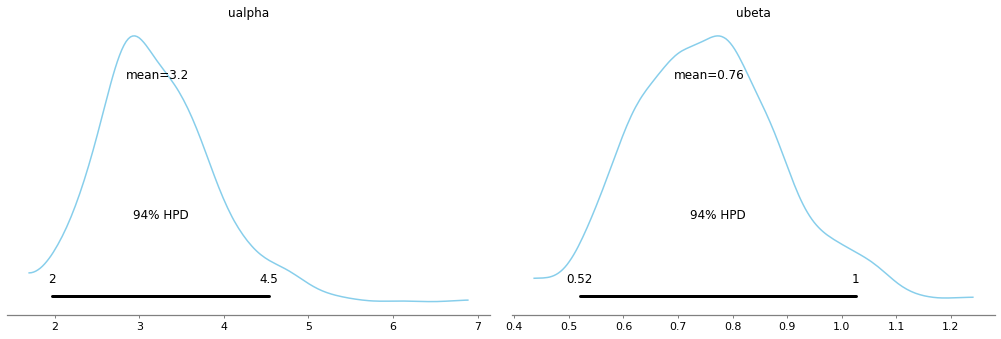

In [20]:
from pymc3 import plot_posterior

plot_posterior(rainfall_trace[100:], 
                varnames=['ualpha', 'ubeta'],
                color='#87ceeb');

## Trying To Fit The Data using the alpha and beta values

/Users/makinsane/anaconda3/lib/python3.7/site-packages/pandas/plotting/_core.py:2477: MatplotlibDeprecationWarning: 
The 'normed' kwarg was deprecated in Matplotlib 2.1 and will be removed in 3.1. Use 'density' instead.
  ax.hist(values, bins=bins, **kwds)


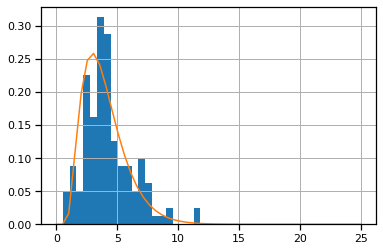

In [21]:
from scipy.stats.distributions import gamma

ualpha_posterior_mean = 3.2
ubeta_posterior_mean = 0.76

precip.Apr.hist(normed=True, bins=20)
plt.plot(np.linspace(0, 25), gamma.pdf(np.linspace(0, 25), ualpha_posterior_mean, ubeta_posterior_mean))

## Since Exponential was the best fit, We try fitting it for all the months

In [68]:
from pymc3 import Model, Uniform , Normal , Exponential

with Model() as rainfall_model:
    ualpha_all = Exponential('ualpha_all', 2/5 )
    ubeta_all = Exponential('ubeta_all',2/5)


with rainfall_model:
    jan_like = Gamma('all_months', alpha=ualpha_all, beta=ubeta_all, observed=precip)

In [69]:
from pymc3 import fit

with rainfall_model: 
    rainfall_trace = fit(random_seed=RANDOM_SEED).sample(1000)

Average Loss = 3,822.6: 100%|██████████| 10000/10000 [00:02<00:00, 3568.68it/s]
Finished [100%]: Average Loss = 3,821.5


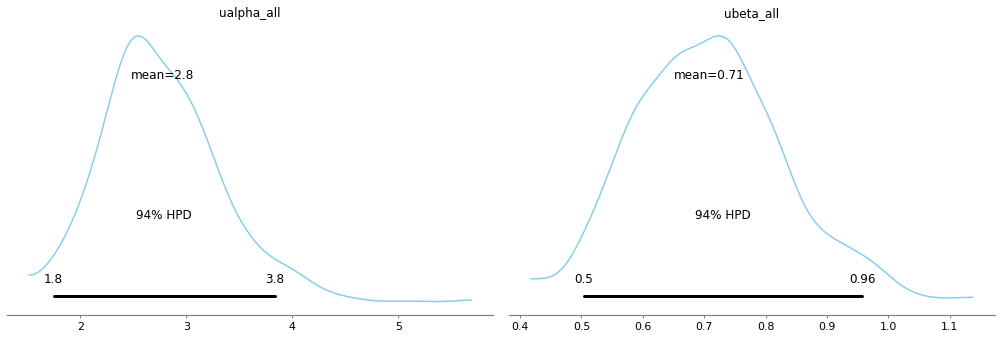

In [70]:
from pymc3 import plot_posterior

plot_posterior(rainfall_trace[100:], 
                varnames=['ualpha_all', 'ubeta_all'],
                color='#87ceeb');

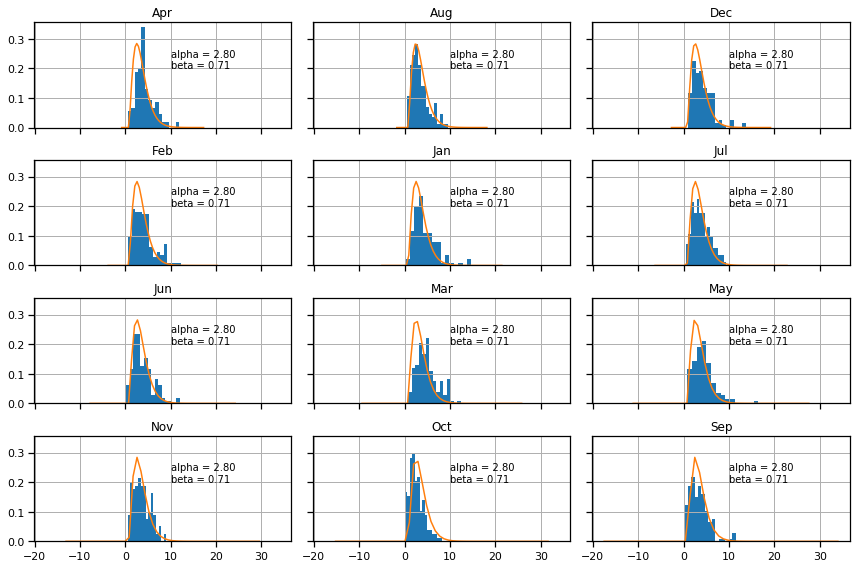

In [72]:
axs = precip.hist(normed=True, figsize=(12, 8), sharex=True, sharey=True, bins=15, grid=True)

for ax in axs.ravel():

    # Get month
    m = ax.get_title()

    # Plot fitted distribution
    x = np.linspace(*ax.get_xlim())
    ax.plot(x, gamma.pdf(x,2.8, 0.71))

    # Annotate with parameter estimates
    label = 'alpha = {0:.2f}\nbeta = {1:.2f}'.format(2.8,0.71)
    ax.annotate(label, xy=(10, 0.2))

plt.tight_layout()